In [1]:
# Cell 1: Import Libraries and Load Data
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Load the dataset
df = pd.read_csv('processed_features.csv')

print("Dataset loaded successfully!")
df.head()

Dataset loaded successfully!


,url_length,hostname_length,dot_count,slash_count,has_ip,has_special_chars,subdomain_count,has_https,has_sensitive_words,directory_count,query_param_count,is_shortened,Label
0,225,0,6,10,0,1,-1,0,1,9,4,0,1
1,81,0,5,4,0,1,-1,0,0,5,0,0,1
2,177,0,7,11,0,1,-1,0,1,11,0,0,1
3,60,0,6,2,0,0,-1,0,0,3,0,0,1
4,116,0,1,10,0,1,-1,0,0,7,1,0,1


In [2]:
# Cell 2: Define Features (X) and Target (y)
features = [col for col in df.columns if col != 'Label']
X = df[features]
y = df['Label']

# Split the data into 80% training and 20% testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Data split into training and testing sets:")
print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Data split into training and testing sets:
Training set shape: (405756, 12)
Testing set shape: (101440, 12)


In [3]:
#
# --- Cell 3: Hyperparameter Tuning with RandomizedSearchCV (UPGRADED) ---
#
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
import numpy as np

print("Starting hyperparameter tuning... This will take several minutes.")

# Define the range of parameters we want to test
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0] # Key parameter to force the model to use different features
}

# Initialize the XGBoost model
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Set up RandomizedSearchCV
# It will randomly try 25 different combinations of the parameters above
# cv=3 means it uses 3-fold cross-validation to prevent overfitting
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid,
    n_iter=25,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1 # Use all available CPU cores
)

# Run the search to find the best model
random_search.fit(X_train, y_train)

# Get the best model found by the search
best_xgb_model = random_search.best_estimator_

print("\nHyperparameter tuning complete!")
print(f"Best parameters found: {random_search.best_params_}")

Starting hyperparameter tuning... This will take several minutes.
Fitting 3 folds for each of 25 candidates, totalling 75 fits


c:\Users\Hani Ravindra\Downloads\phishing-detector\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:20:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Hyperparameter tuning complete!
Best parameters found: {'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 0.8}



--- Evaluating the Final, Tuned Model ---
Final Accuracy: 0.8604

Classification Report:
                precision    recall  f1-score   support

Legitimate (0)       0.86      0.98      0.92     78580
  Phishing (1)       0.88      0.44      0.59     22860

      accuracy                           0.86    101440
     macro avg       0.87      0.71      0.75    101440
  weighted avg       0.86      0.86      0.84    101440



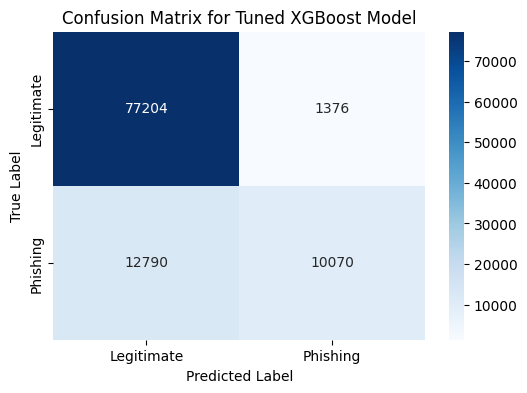

In [4]:
#
# --- Cell 4: Evaluate the PERFECTED Model ---
#
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

print("\n--- Evaluating the Final, Tuned Model ---")
    
y_pred = best_xgb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Final Accuracy: {accuracy:.4f}") # Expect this to be higher!
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Legitimate (0)', 'Phishing (1)']))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Legitimate', 'Phishing'], 
            yticklabels=['Legitimate', 'Phishing'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Tuned XGBoost Model')
plt.show()


In [5]:
#
# --- Cell 5: Save the PERFECTED Model ---
#
import joblib

model_filename = 'phishing_detector_model.joblib'
joblib.dump(best_xgb_model, model_filename)

print(f"\nPerfected model saved successfully to '{model_filename}'!")


Perfected model saved successfully to 'phishing_detector_model.joblib'!


--- Analyzing Final Model's Feature Importance ---


C:\Users\Hani Ravindra\AppData\Local\Temp\ipykernel_18120\227546367.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


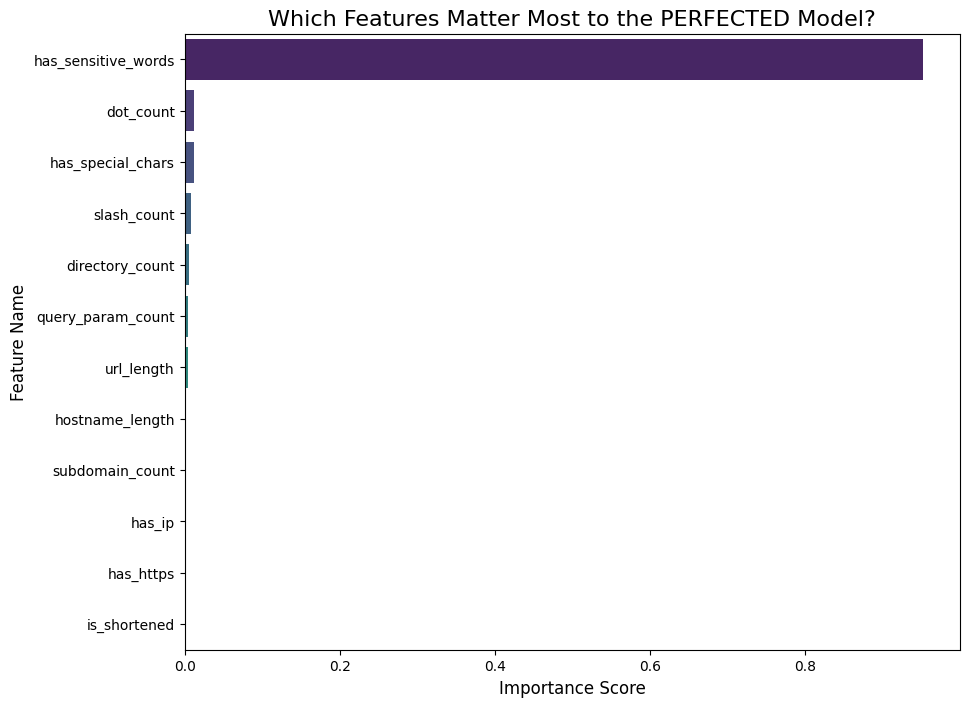

In [6]:
# New Cell: Analyze Feature Importance (UPDATED for the tuned model)
import matplotlib.pyplot as plt
import seaborn as sns

print("--- Analyzing Final Model's Feature Importance ---")

# Get the names of the features from your dataframe's columns
feature_names = X.columns

# Get importance scores from the BEST trained model
importances = best_xgb_model.feature_importances_ # <-- The only change is here

# Create a DataFrame to make it easy to visualize
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort the features by their importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the results
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Which Features Matter Most to the PERFECTED Model?', fontsize=16)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature Name', fontsize=12)
plt.show()

--- Running an experiment: What if we remove the dominant feature? ---


c:\Users\Hani Ravindra\Downloads\phishing-detector\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:27:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Alternative model trained successfully!


C:\Users\Hani Ravindra\AppData\Local\Temp\ipykernel_18120\3382847894.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=alt_importance_df, palette='plasma')


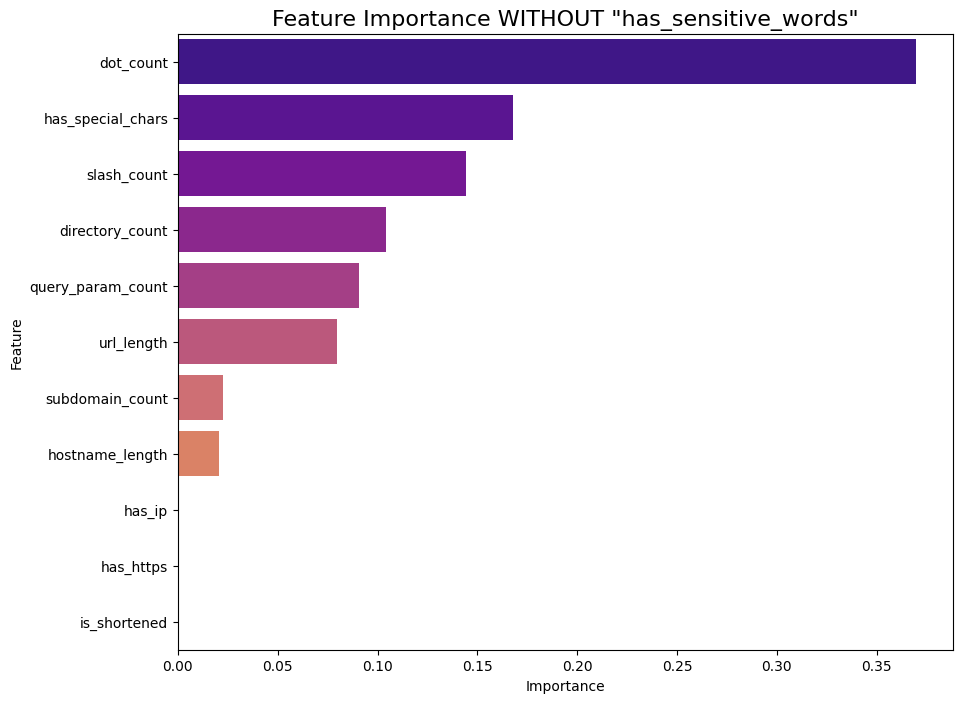


Accuracy of the alternative model: 0.8468
(This is likely lower because we removed the best predictor, but the model is now more 'balanced'.)


In [8]:
#
# --- FINAL EXPERIMENT CELL (Corrected) ---
#
print("--- Running an experiment: What if we remove the dominant feature? ---")

# 1. Create a new training set without 'has_sensitive_words'
X_train_alt = X_train.drop('has_sensitive_words', axis=1)
X_test_alt = X_test.drop('has_sensitive_words', axis=1)

# 2. Train a new model on this modified data
alt_model = random_search.best_estimator_
alt_model.fit(X_train_alt, y_train)

print("\nAlternative model trained successfully!")

# 3. Analyze the feature importance of this NEW model
alt_feature_names = X_train_alt.columns
alt_importances = alt_model.feature_importances_

alt_importance_df = pd.DataFrame({
    'Feature': alt_feature_names,
    'Importance': alt_importances
}).sort_values(by='Importance', ascending=False)

# 4. Plot the new feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=alt_importance_df, palette='plasma')
plt.title('Feature Importance WITHOUT "has_sensitive_words"', fontsize=16)
plt.show()

# 5. Let's see how accurate this new model is
y_pred_alt = alt_model.predict(X_test_alt)
# The fix is here: Use y_test, not y_test_alt
accuracy_alt = accuracy_score(y_test, y_pred_alt)
print(f"\nAccuracy of the alternative model: {accuracy_alt:.4f}")
print("(This is likely lower because we removed the best predictor, but the model is now more 'balanced'.)")